In [ ]:
from google.colab import drive
drive.mount('/content/drive')

![](https://drive.google.com/uc?export=view&id=1_Y5cKUrCs8r9ZiVfzmgpfJJOQum_we39)

**Preparing data**

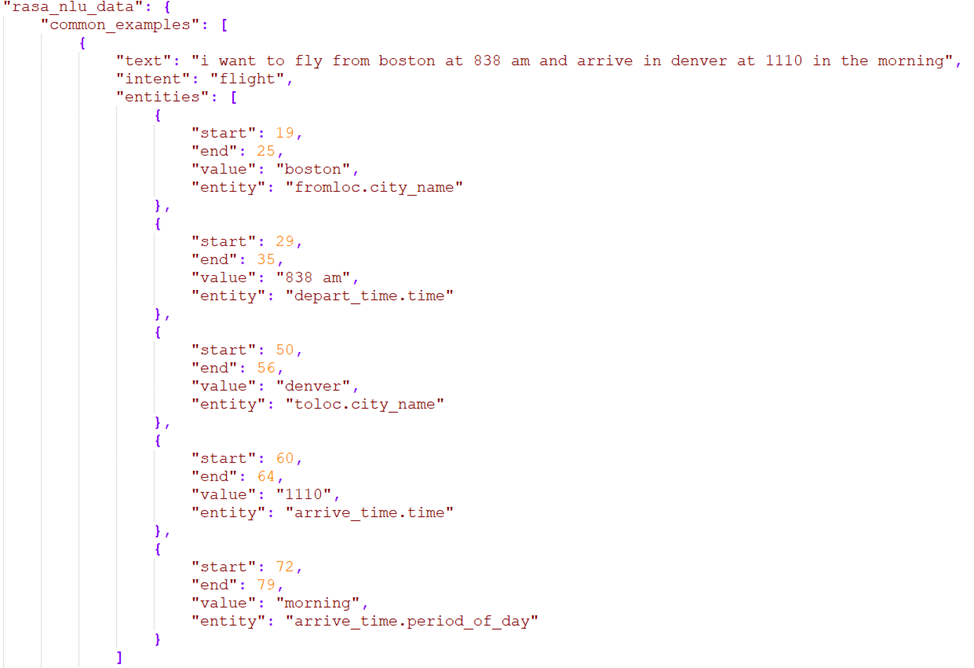

<div dir=rtl>
بعد از خواندن داده، برای هر کلمه‌ی موجود در جمله، برچسب متناظر با آن در تابع find_label_of_sequences استخراج می‌شود. آرایه seq_label که نشان‌دهنده‌ی برچسب متناظر کلمات جمله هست، شروع می‌گردد (کلماتی که در جمله هستند و هیچ برچسبی به آنها نسبت داده نشده، برچسب ‘O’ می‌گیرند). برچسب  المانی که نماینده‌ی نشانه‌ی شروع یک کلمه است، تحت شرایط تعریف شده به روز می‌شود.  
</div>

In [ ]:
import json

def read_json_file (PATH):

  f = open (PATH, "r")

  # Reading from file
  data = json.loads(f.read())
  data = data['rasa_nlu_data']
  data = data['common_examples']

  sentences = []
  indexes = []
  labels = []

  # Iterating through the json
  for sample in data:
      sentences.append(sample['text'])
      index = []
      label = []
      
      # extract the start and end tokens of each entity with the corresponding label within the sentence
      for elem in sample['entities']:
        index.append((elem['start'], elem['end']))
        label.append(elem['entity'])

      indexes.append(index)
      labels.append(label)

  # Closing file
  f.close()
  return sentences, labels, indexes

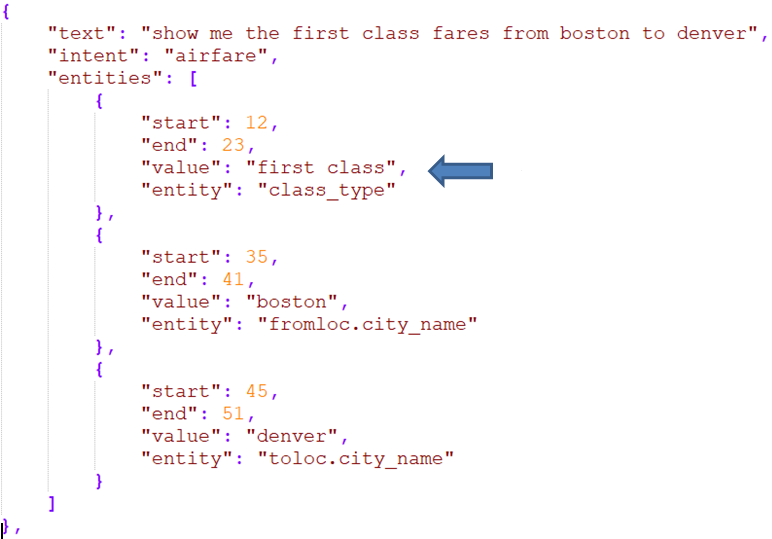

In [ ]:
import re

# In this function we iterate over tokens of an input sentence and finds label of them
def find_label_of_sequences(sentences, labels, indexes):
  seq_tags = []
  
  for sent, label, index in zip (sentences, labels, indexes):
    # find start token of each word within the input sentence
    res = [ele.start() for ele in re.finditer(r'\S+', sent)]
    word_index = 0
    # initialize the label of all of the tokens with 'O' for sentence 'sent'
    seq_label = [tags2index['O'] for i in range(0, len(res))]
    # iterate over each word of the sentnce 
    for elem in res:
      tag_index = 0
      # check whether the token exists in one of the time_slot indexes
      for tag in index:
        if elem == tag[0] or (elem < tag[1] and elem > tag[0]):
          # update the label of 'word_index' token to its label 
          seq_label[word_index] = tags2index[label[tag_index]]
        tag_index += 1
      word_index+=1
    seq_tags.append(seq_label)
  return seq_tags


In [ ]:
import re
sent='what flights are available from pittsburgh to baltimore on thursday morning'
tmp = [ele.start() for ele in re.finditer(r'\S+', sent)]
print(tmp)

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/rasa_nlu/train.json"
TEST_PATH = "/content/drive/MyDrive/rasa_nlu/test.json"
 
sentences_train, labels_train, indexes_train = read_json_file(TRAIN_PATH)
sentences_test, labels_test, indexes_test = read_json_file(TEST_PATH)


In [ ]:
unique_tags = ['O']

total_labels = labels_train + labels_test

for labels in total_labels:
  for label in labels:
    unique_tags.append(label)

unique_tags = set(unique_tags)

In [ ]:
n_tags = len(unique_tags)

In [ ]:
n_tags

In [ ]:
tags2index = {t:i for i,t in enumerate(unique_tags)}

In [ ]:
tags2index

In [ ]:
seq_tags_train = find_label_of_sequences(sentences_train, labels_train, indexes_train)
seq_tags_test = find_label_of_sequences(sentences_test, labels_test, indexes_test)

<div dir=rtl>
در ادامه از توکنایزر استفاده شده است و با استفاده از تابع texts_to_sequences جملات به آرایه‌ای از کلمات تبدیل می‌گردند.  
</div>

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train+sentences_test)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1 

In [ ]:
sent_length = {}

for elem in X_train:
  res = len(elem)
  if res in sent_length:
    sent_length[res]+=1
  else:
    sent_length[res]=1

print(sent_length)

In [ ]:
import matplotlib.pyplot as plt

x = [key for key in sent_length]
y = [sent_length[key] for key in sent_length]

plt.scatter(x, y)
plt.show()

In [ ]:
max_len = 20

<div dir=rtl> جملات و برچسب‌های آن‌ها به حداکثر طول، pad  می‌شوند. 
</div>

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [ ]:
seq_tags_train = pad_sequences(seq_tags_train,  padding='post', maxlen=max_len, value=tags2index["O"])
seq_tags_test = pad_sequences(seq_tags_test,  padding='post', maxlen=max_len, value=tags2index["O"])

In [ ]:
seq_tags_train = seq_tags_train.reshape(seq_tags_train.shape[0], seq_tags_train.shape[1], 1)
seq_tags_test = seq_tags_test.reshape(seq_tags_test.shape[0], seq_tags_test.shape[1], 1)


<div dir=rtl>
مدل شامل یک لایه جاسازی ، یک شبکه عصبی بازگشتی دوجهته و یک لایه‌ی متراکم  برای پیش‌بینی  و طبقه‌بندی برچسب متناظر هر کلمه است.
</div>

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, GRU

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len,
                           trainable=True))

model.add(Bidirectional(GRU(300, dropout=0.2,  return_sequences=True)))
model.add(Dense(n_tags, activation="softmax"))


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
batch_size = 32
import numpy as np

history = model.fit(np.array(X_train), seq_tags_train, validation_data=(np.array(X_test), seq_tags_test),
                    batch_size=batch_size, epochs=6, verbose=1)

In [ ]:
pred = model.predict(np.array(X_test))

In [ ]:
np.shape(pred)

In [ ]:
pred = pred.reshape(pred.shape[0]*pred.shape[1], pred.shape[2])

In [ ]:
np.shape(pred)

In [ ]:
predicted_label = [np.argmax(elem) for elem in pred]

In [ ]:
test_label = seq_tags_test.reshape(seq_tags_test.shape[0]*seq_tags_test.shape[1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predicted_label, test_label))